In [6]:
%load_ext autoreload

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [4]:
import pandas as pd
from tqdm import tqdm
import torch
import sys
import time
import datetime
from itertools import product
import os

In [5]:
import logging
logger = logging.getLogger("molecules")
logger.setLevel(logging.INFO)

fh = logging.FileHandler('logs.log')
fh.setLevel(logging.INFO)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [6]:
logger.info("asd")

asd


In [7]:
%autoreload 2
from huggingmolecules import MatConfig, MatFeaturizer, MatModel
from huggingmolecules import GroverConfig, GroverFeaturizer, GroverModel
from huggingmolecules import RMatConfig, RMatFeaturizer, RMatModel
from models import StrippedMatModel, StrippedGroverModel, StrippedRMatModel

In [8]:
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl

logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

In [9]:
# from mat import MolecularAttentionTransformer

# model = MolecularAttentionTransformer()
# model.predict(["CN1CC[C@]23C(=O)C[C@@H]4C(=CCO[C@H]5CC(=O)N(c6ccccc62)[C@@H]3[C@@H]54)C1"]) ## tooks 11m 4s (!)

In [7]:
%autoreload 2
from utils import get_embedder_names, get_embedder
from datasets import get_dataset_names, get_dataset

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/michlampert/magisterka/venv/lib64/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.


In [16]:
len(list(product(get_dataset_names(), get_embedder_names())))

248

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import linear_model
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score
import matplotlib.pyplot as plt
from functools import partial
import os

In [2]:
def write_to_file(content):
    with open("results.md", "a") as f:
        f.write(content)
        f.write("\n\n")

In [21]:
write_to_file(f"# Decision Tree models")

In [3]:
def evaluate(df, split_idx, model, metric):
    targets = list(filter(lambda col: col not in ['smiles', "features", 'embeddings', 'Drug_ID'], df.columns))
    
    train = df.loc[split_idx["train"]].dropna()
    X = np.vstack(train.embeddings.to_numpy())
    y = train[targets].to_numpy()
    
    clf = model().fit(X, y)
    
    train_res = metric(clf.predict(X), y)
    
    valid = df.loc[split_idx["valid"]].dropna()
    X = np.vstack(valid.embeddings.to_numpy())
    y = valid[targets].to_numpy()
    valid_res = metric(clf.predict(X), y)
    
    test = df.loc[split_idx["test"]].dropna()
    X = np.vstack(test.embeddings.to_numpy())
    y = test[targets].to_numpy()
    test_res = metric(clf.predict(X), y)
    
    return {"train": [train_res], "valid": [valid_res], "test": [test_res]}


regression_tree_error = partial(evaluate, model=lambda: tree.DecisionTreeRegressor(), metric=lambda pred, y: np.sqrt(mean_squared_error(pred, y)))
classification_tree_metric = partial(evaluate, model=lambda: tree.DecisionTreeClassifier(), metric=lambda pred, y: f1_score(pred, y, average="macro"))
regression_lin_error = partial(evaluate, model=lambda: linear_model.LinearRegression(), metric=lambda pred, y: np.sqrt(mean_squared_error(pred, y)))


classification_metric = partial(evaluate, metric=lambda pred, y: f1_score(pred, y, average="macro"))
classification_lin_metric = partial(classification_metric, model=lambda: ClassifierChain(LogisticRegression()))

# classification_lin_metric = partial(evaluate, model=lambda: linear_model.LogisticRegression(), metric=lambda pred, y: f1_score(pred, y, average="macro"))

In [11]:
def regression_error(df, split_idx):
    targets = list(filter(lambda col: col not in ['smiles', "features", 'embeddings', 'Drug_ID'], df.columns))
    
    train = df.loc[split_idx["train"]].dropna()
    X = np.vstack(train.embeddings.to_numpy())
    y = train[targets].to_numpy()
    
    clf = linear_model.LinearRegression()
    clf = clf.fit(X, y)
    
    train_res = np.sqrt(mean_squared_error(clf.predict(X), y))
    
    valid = df.loc[split_idx["valid"]].dropna()
    X = np.vstack(valid.embeddings.to_numpy())
    y = valid[targets].to_numpy()
    valid_res = np.sqrt(mean_squared_error(clf.predict(X), y))
    
    test = df.loc[split_idx["test"]].dropna()
    X = np.vstack(test.embeddings.to_numpy())
    y = test[targets].to_numpy()
    test_res = np.sqrt(mean_squared_error(clf.predict(X), y))
    
    return {"train": [train_res], "valid": [valid_res], "test": [test_res]}

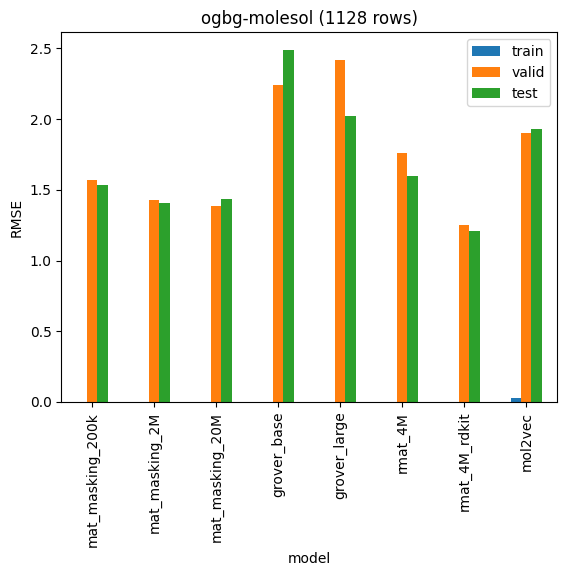

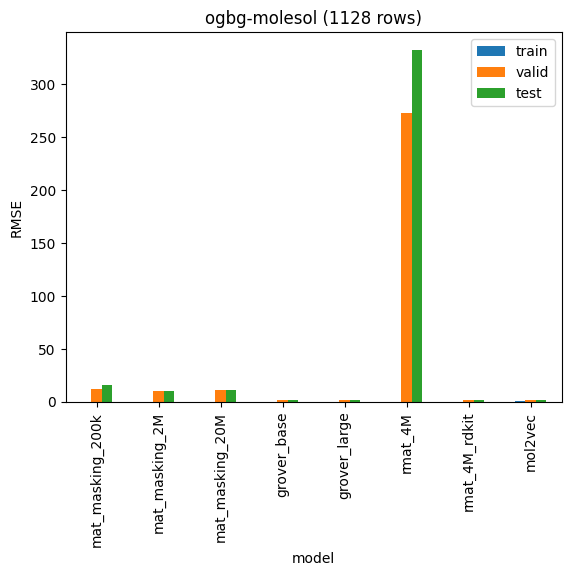

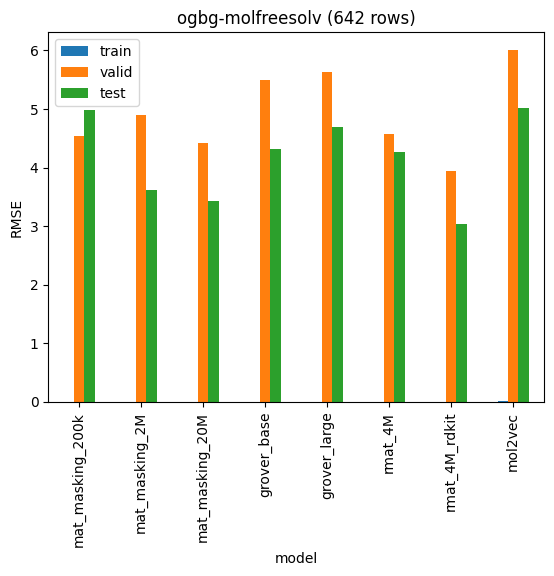

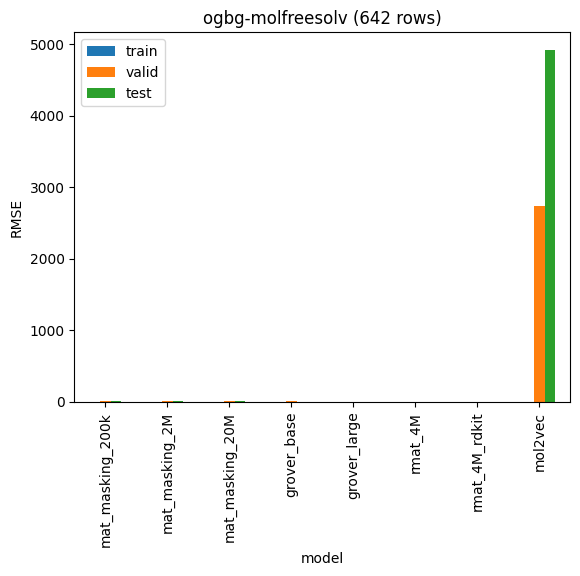

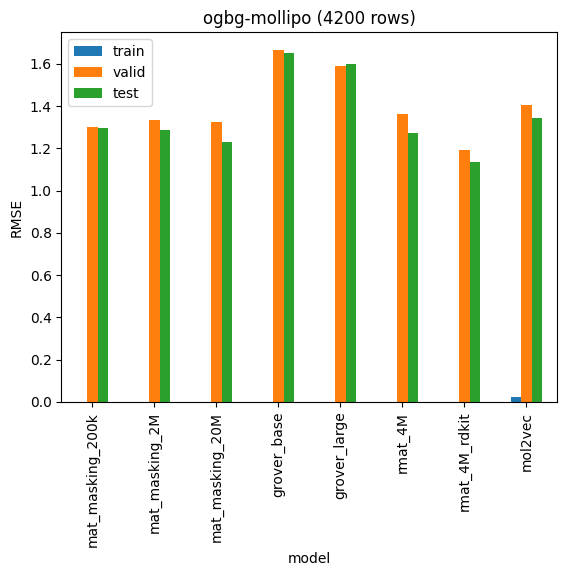

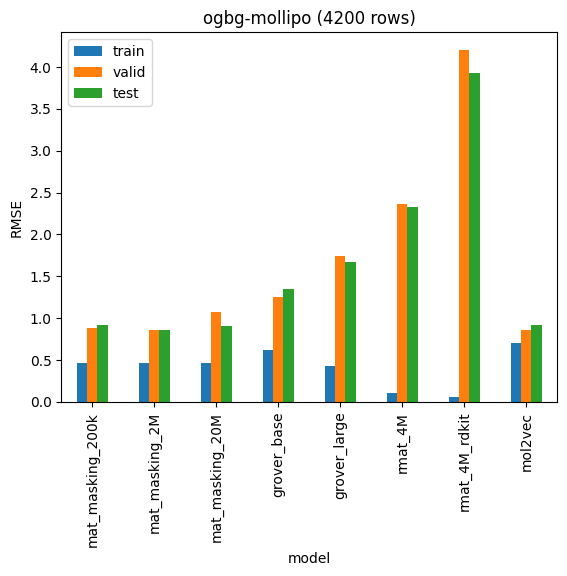

In [32]:
regression_datasets = [
    "ogbg-molesol", "ogbg-molfreesolv", "ogbg-mollipo"
]

write_to_file(f"# OGB regression")

for dataset_name in regression_datasets:
    res_tree = pd.DataFrame()
    res_lin = pd.DataFrame()
    
    if os.path.isdir(f"embeddings/{dataset_name}"):
    
        dataset, split_idx = get_dataset(dataset_name)
        rows_count = len(dataset)
        
        for name in get_embedder_names():
            if os.path.isfile(f"embeddings/{dataset_name}/{name}.zip"):
                df = pd.read_pickle(f"embeddings/{dataset_name}/{name}.zip")

                res_tree = pd.concat([res_tree, pd.DataFrame(regression_tree_error(df, split_idx), index=[name])])
                res_lin = pd.concat([res_lin, pd.DataFrame(regression_lin_error(df, split_idx), index=[name])])
        
        try:    
            res_tree.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows)", ylabel="RMSE", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res_tree.png", bbox_inches="tight")
            res_lin.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows)", ylabel="RMSE", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res_lin.png", bbox_inches="tight")
            
            write_to_file(f"## {dataset_name} ({rows_count} rows)")
            write_to_file(f"### Decision Tree regression")
            write_to_file(res_tree.to_markdown())
            write_to_file(f"![plot](plots/{dataset_name}_res_tree.png)")
            write_to_file(f"### Linear regression")
            write_to_file(res_lin.to_markdown())
            write_to_file(f"![plot](plots/{dataset_name}_res_lin.png)")
        except Exception as e:
            write_to_file(f"## {dataset_name} ({rows_count} rows)")
            write_to_file(f"*Problem with data*")
            write_to_file(e)

In [45]:
def classification_metric(df, split_idx):
    targets = list(filter(lambda col: col not in ['smiles', "features", 'embeddings', 'Drug_ID'], df.columns))
    
    train = df.loc[split_idx["train"]].dropna()
    X = np.vstack(train.embeddings.to_numpy())
    y = train[targets].to_numpy()
    
    clf = tree.DecisionTreeClassifier(min_samples_leaf=10)
    clf = clf.fit(X, y)
    
    train_res = f1_score(clf.predict(X), y, average="macro")
    
    valid = df.loc[split_idx["valid"]].dropna()
    X = np.vstack(valid.embeddings.to_numpy())
    y = valid[targets].to_numpy()
    valid_res = f1_score(clf.predict(X), y, average="macro")
    
    test = df.loc[split_idx["test"]].dropna()
    X = np.vstack(test.embeddings.to_numpy())
    y = test[targets].to_numpy()
    test_res = f1_score(clf.predict(X), y, average="macro")
    
    return {"train": [train_res], "valid": [valid_res], "test": [test_res]}

need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate
need at least one array to concatenate


TypeError: no numeric data to plot

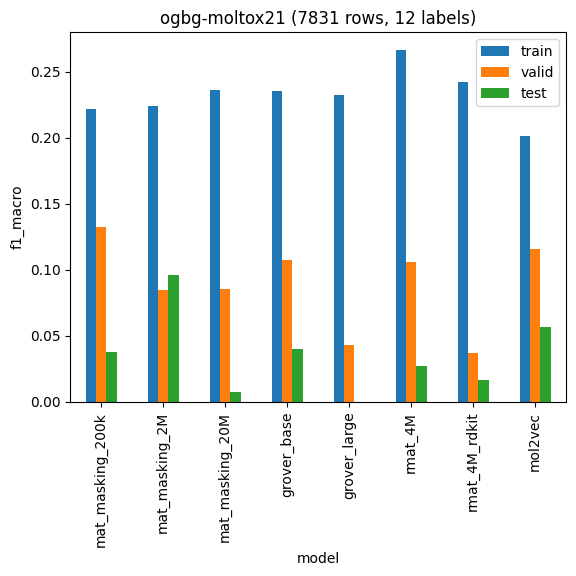

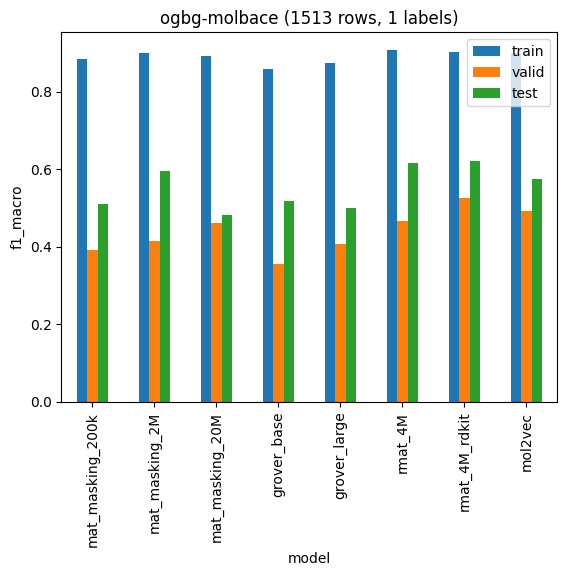

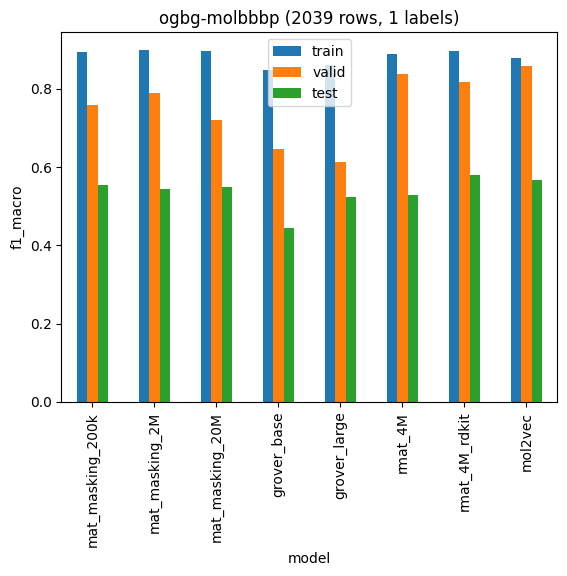

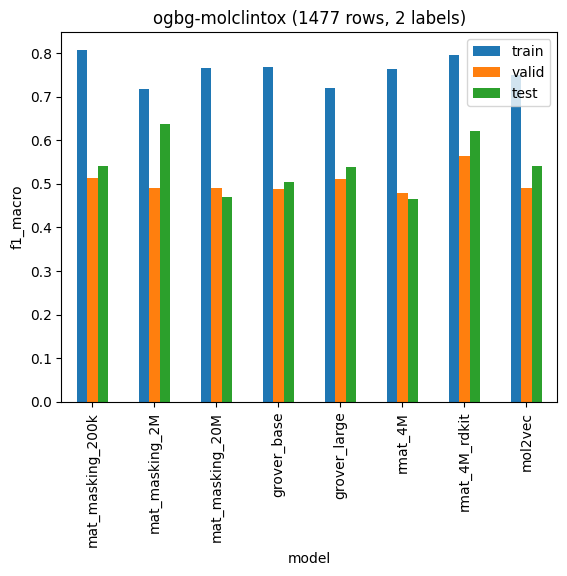

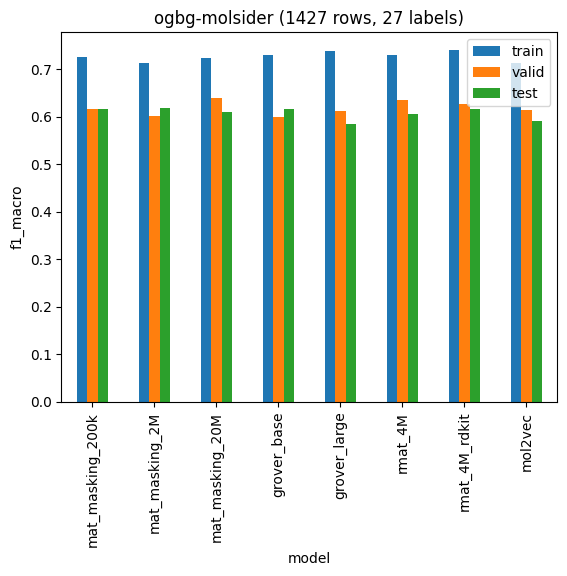

In [35]:
classification_datasets = [
    # "ogbg-moltox21",
    # "ogbg-molbace",
    # "ogbg-molbbbp",
    # "ogbg-molclintox",
    # "ogbg-molmuv",
    # "ogbg-molsider",
    # "ogbg-moltoxcast"
]

with open("results.md", "a") as f:
    f.write(f"## OGB multi-label classification")
    f.write("\n\n")

for dataset_name in classification_datasets:
    tmp = pd.DataFrame()
    
    if os.path.isdir(f"embeddings/{dataset_name}"):
    
        dataset, split_idx = get_dataset(dataset_name)
        labels_count = len(list(filter(lambda col: col not in ['smiles', "features", 'embeddings'], dataset.columns)))
        rows_count = len(dataset)
        
        for name in get_embedder_names():
            if os.path.isfile(f"embeddings/{dataset_name}/{name}.zip"):
                try:
                    df = pd.read_pickle(f"embeddings/{dataset_name}/{name}.zip")

                    tmp = pd.concat([tmp, pd.DataFrame(classification_metric(df, split_idx), index=[name])])
                except Exception as e:
                    print(e)
        try:
            tmp.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows, {labels_count} labels)", ylabel="f1_macro", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res.png", bbox_inches="tight")
            with open("results.md", "a") as f:
                f.write(f"### {dataset_name} ({rows_count} rows, {labels_count} labels)")
                f.write("\n\n")
                f.write(tmp.to_markdown())
                f.write("\n\n")
                f.write(f"![plot](plots/{dataset_name}_res.png)")
                f.write("\n\n")
        except Exception as e:
                print(e)
            
            
        

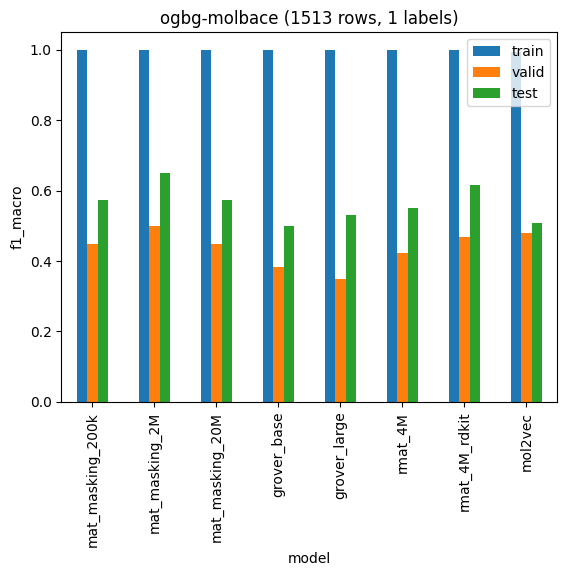

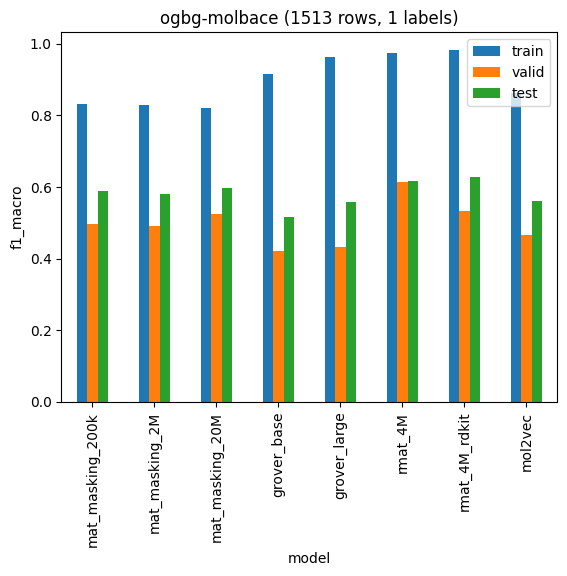

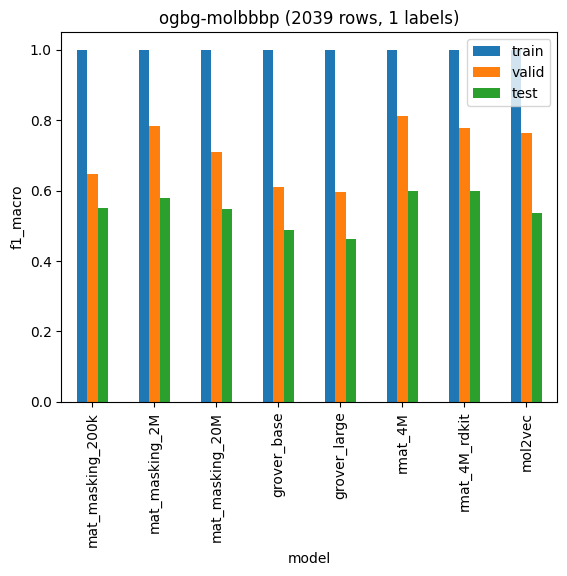

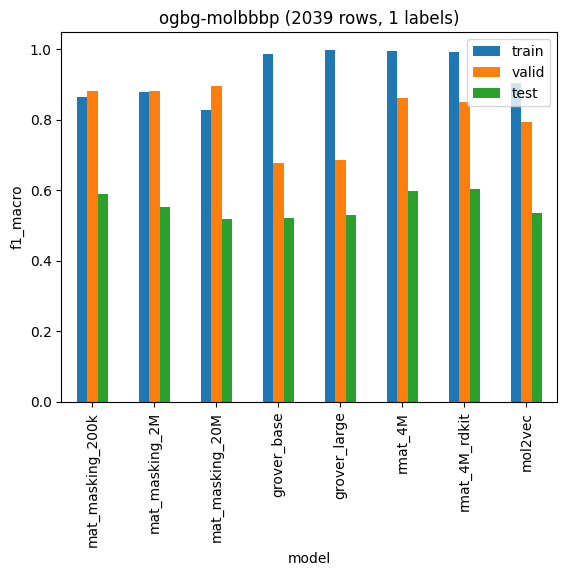

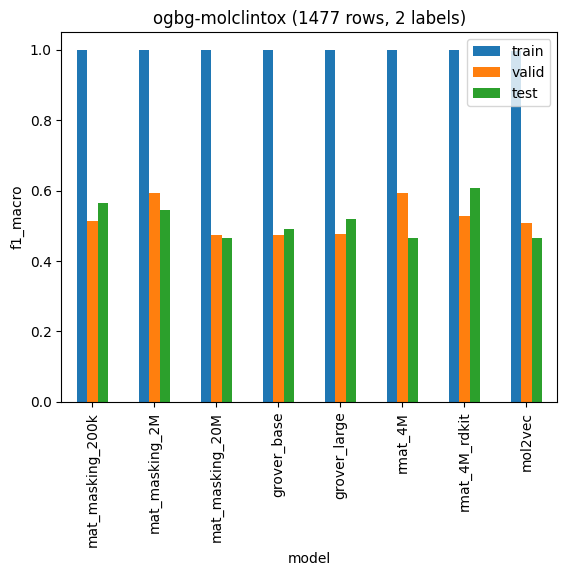

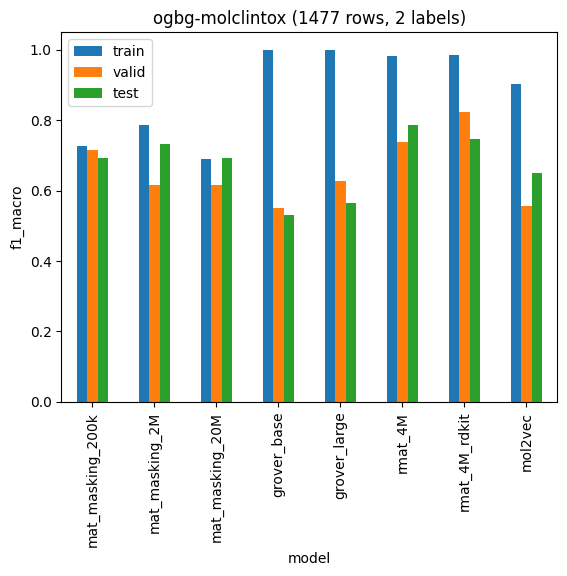

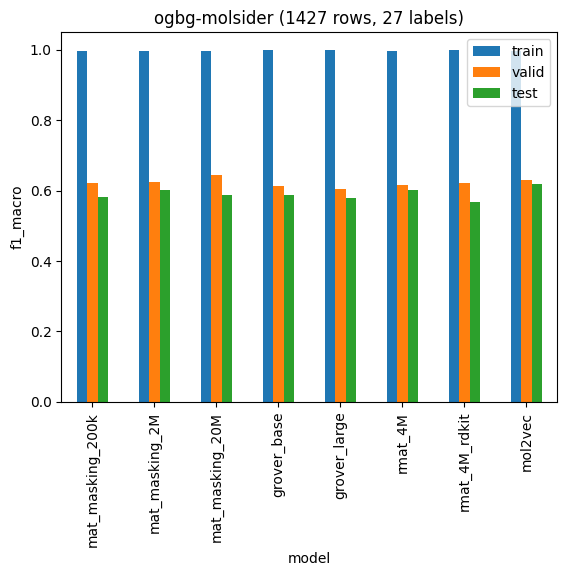

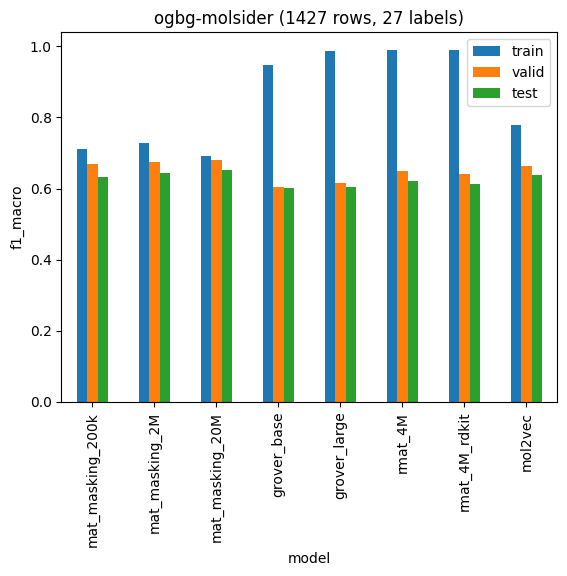

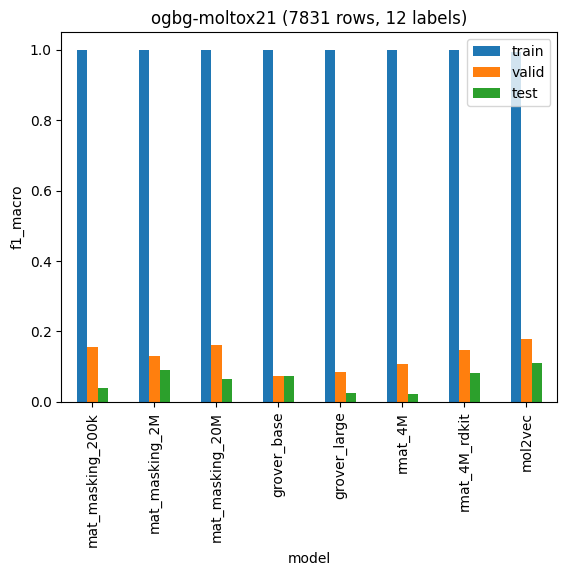

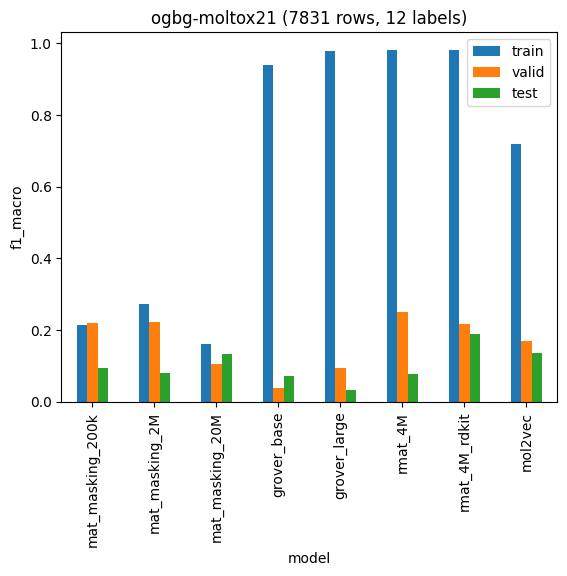

In [8]:
classification_datasets = [
    # "ogbg-molbace",
    # "ogbg-molbbbp",
    # "ogbg-molclintox",
    # "ogbg-molsider",
    "ogbg-moltox21",
    "ogbg-moltoxcast"
    "ogbg-molmuv",
]

write_to_file(f"# OGB classification")

for dataset_name in classification_datasets:
    res_tree = pd.DataFrame()
    res_lin = pd.DataFrame()
    
    if os.path.isdir(f"embeddings/{dataset_name}"):
    
        dataset, split_idx = get_dataset(dataset_name)
        labels_count = len(list(filter(lambda col: col not in ['smiles', "features", 'embeddings'], dataset.columns)))
        rows_count = len(dataset)
        
        for name in get_embedder_names():
            if os.path.isfile(f"embeddings/{dataset_name}/{name}.zip"):
                df = pd.read_pickle(f"embeddings/{dataset_name}/{name}.zip")

                res_lin = pd.concat([res_lin, pd.DataFrame(classification_lin_metric(df, split_idx), index=[name])])
                res_tree = pd.concat([res_tree, pd.DataFrame(classification_tree_metric(df, split_idx), index=[name])])
        
        try:
            res_tree.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows, {labels_count} labels)", ylabel="f1_macro", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res_tree.png", bbox_inches="tight")
            
            res_lin.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows, {labels_count} labels)", ylabel="f1_macro", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res_lin.png", bbox_inches="tight")
            
            write_to_file(f"## {dataset_name} ({rows_count} rows, {labels_count} labels)")
            write_to_file(f"### Decision Tree classifier")
            write_to_file(res_tree.to_markdown())
            write_to_file(f"![plot](plots/{dataset_name}_res_tree.png)")
            write_to_file(f"### Linear classifier")
            write_to_file(res_lin.to_markdown())
            write_to_file(f"![plot](plots/{dataset_name}_res_lin.png)")
        except Exception as e:
            write_to_file(f"## {dataset_name} ({rows_count} rows)")
            write_to_file(f"*Problem with data*")
            write_to_file(e)

Found local copy...
Loading...
Done!


Found local copy...
Loading...
Done!


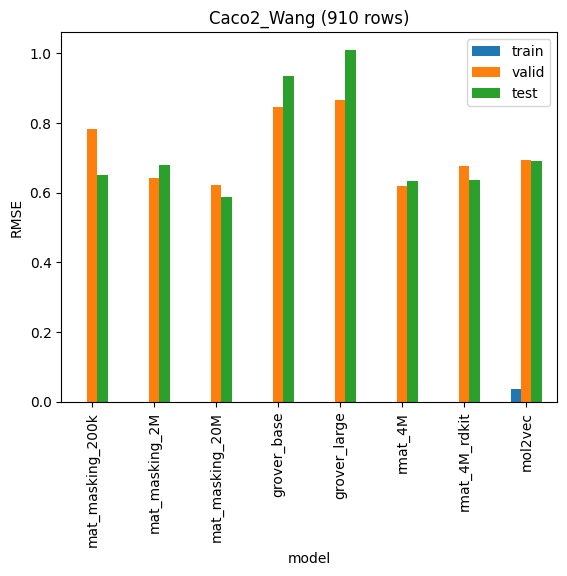

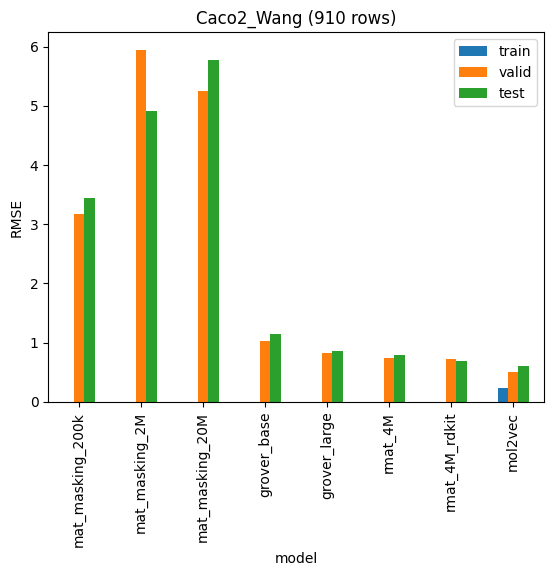

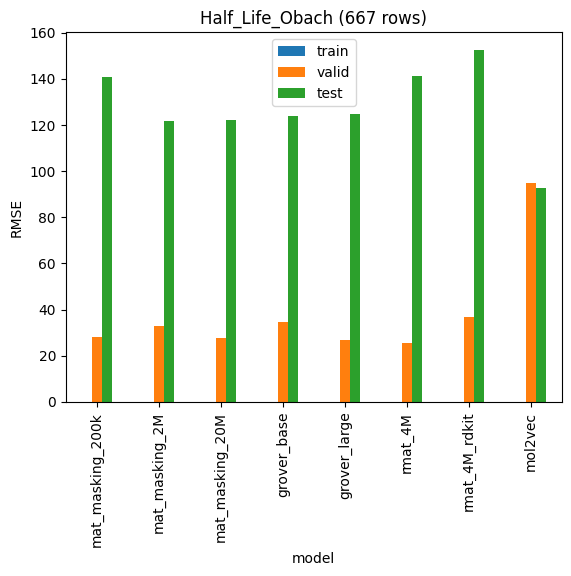

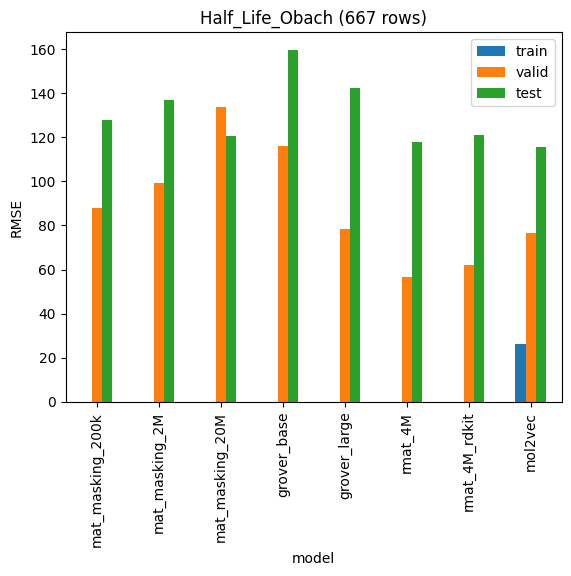

In [9]:
regression_datasets = [
        'Caco2_Wang',
        'Half_Life_Obach',
        'Lipophilicity_AstraZeneca',
        'Solubility_AqSolDB',
        'HydrationFreeEnergy_FreeSolv',
        'PPBR_AZ',
        'VDss_Lombardo',
        'Clearance_Hepatocyte_AZ',
    ]

write_to_file(f"# TDC regression")

for dataset_name in regression_datasets:
    res_tree = pd.DataFrame()
    res_lin = pd.DataFrame()
    
    if os.path.isdir(f"embeddings/{dataset_name}"):
    
        dataset, split_idx = get_dataset(dataset_name)
        rows_count = len(dataset)
        
        for name in get_embedder_names():
            if os.path.isfile(f"embeddings/{dataset_name}/{name}.zip"):
                df = pd.read_pickle(f"embeddings/{dataset_name}/{name}.zip")

                res_tree = pd.concat([res_tree, pd.DataFrame(regression_tree_error(df, split_idx), index=[name])])
                res_lin = pd.concat([res_lin, pd.DataFrame(regression_lin_error(df, split_idx), index=[name])])
        
        try:    
            res_tree.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows)", ylabel="RMSE", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res_tree.png", bbox_inches="tight")
            res_lin.plot.bar(ylim=(0, None), title=f"{dataset_name} ({rows_count} rows)", ylabel="RMSE", xlabel="model")
            plt.savefig(f"plots/{dataset_name}_res_lin.png", bbox_inches="tight")
            
            write_to_file(f"## {dataset_name} ({rows_count} rows)")
            write_to_file(f"### Decision Tree regression")
            write_to_file(res_tree.to_markdown())
            write_to_file(f"![plot](plots/{dataset_name}_res_tree.png)")
            write_to_file(f"### Linear regression")
            write_to_file(res_lin.to_markdown())
            write_to_file(f"![plot](plots/{dataset_name}_res_lin.png)")
        except Exception as e:
            write_to_file(f"## {dataset_name} ({rows_count} rows)")
            write_to_file(f"*Problem with data*")
            write_to_file(e)